# Connecting tickets from launchpad with their corresponding issue in gerrit and measure time to close the ticket - Now including 2016 history.

In [2]:
# importing needed libraries and establishing a connection to the database
import MySQLdb
import pandas

def connect():
   user = "root"
   password = ""
   host = "localhost"
   db = "report_time"
   port=3306
   use_unicode=True

   try:
      db = MySQLdb.connect(user = user, passwd = password, db = db, port = port, use_unicode = use_unicode)
      return db, db.cursor()
   except:
      logging.error("Database connection error!")
      raise
        
def execute_query(connector, query):
   results = int (connector.execute(query))
   cont = 0
   if results > 0:
      result1 = connector.fetchall()
      return result1
   else:
      return []
    
db, cursor = connect()

### Collection of data from Launchpad

1. We need the identification of the issue in gerrit that is reviewing the ticket, and we extract it from the field text in comment table. Given that we are interested in the time needed for closing a ticket, we extract  

Next necessary fields that can be extracted from the same table are:
2. the ticket id in Launchpad,
3. the comment relative to the fix committed.
 
We can identify the comment relative to a commit because it contains these datas in the following format:
#### [1] example:
    Reviewed:  https://review.openstack.org/100018
    Committed: https://git.openstack.org/cgit/openstack/nova/commit/?id=be58dd8432a8d12484f5553d79a02e720e2c0435
    Submitter: Jenkins
    Branch:    master ...

The first problem that arises in the comments is that some of them for some ticket (see example https://bugs.launchpad.net/nova/+bug/1458945) are a summary of some commit history. Therefore, for these cases, we find a match with the datas in [1] within the tet contained in the body of the comment, while the commit itself is not a merge in the master branch of the project that orginated the ticket, consequently not the correct result.

However the format requires that the datas defining the type of comment are stated at the very begining of the comment and analysing the tickets in launxhpad we have seen that they are found in the first 6 rows of the comment.

Thus the first step is data cleaning of the comments, so that we extract just the first 6 lines from every one of them. Doing this assures us in identifying the right commit. 

In [2]:
# use the function substring_index() to extract the first 9 rows from every comment of all the tickets in launchpad
cursor.execute( """ create table comments_H1 as 
select id, 
       issue_id, 
       comment_id, 
       substring_index(text, '\n', 6) as text, 
       submitted_by, 
       submitted_on
from tickets_2016.comments """) 

463683L

If we notice [1], we see that we can identify the gerrit id of the issue fixing the bug in the first row:
##### Reviewed:  https://review.openstack.org/100018

Thus the next step is identifying the comments related to a fix merge, identify the gerrit link and extract the id.

In [3]:
# notice that we are interested only into tickets that have been merged into master branch
cursor.execute (""" create table ticket_issue as
select id, 
       issue_id,
       text as launchpad_comment,
       submitted_on as date_fix_committed,
       substring(text, locate('https://review.openstack.org/', text)+29, 
       locate('Committed', text) - locate('https://review.openstack.org/', text) - 30) 
       as gerrit_id
from comments_H1
where 
instr(text, 'Reviewed') and 
instr(text, 'Committed') and 
instr(text, 'Submitter') and 
instr(text, 'Branch') and 
instr(text, 'master') """)

83318L

We collected 83318 different master merges when 56893 is the number of tickets which status is 'Fix Merged' in Launchpad out of 99134 total tickets. This because a ticket has different merges in master branches of different projects.

In [4]:
# this query extracts the number of distinct issues that have been merged in master branches and were
# collected from the query above in the table ticket_issue 
cursor.execute(" select distinct issue_id from ticket_issue ")

50721L

Analysing the tickets, we have noticed that there are 2 different ways of writing the link to the issue in Gerrit:
1. https://review.openstack.org/100018
2. https://review.openstack.org/#/c/38191

Let's check the pattern of the gerrit_id. We know that the gerrit_id is a numeric string. Let's run a query to see if some extracted gerrit_id contains other than 0-9. From the cases stated above we will check for the '#', '/' and caracters 'a-z' given that in the second link we find the pattern '.../#/c/...':

Thus we run the query:

In [5]:
cursor.execute(""" select gerrit_id 
from ticket_issue
where gerrit_id regexp '[a-z]'
or gerrit_id regexp '#'
or gerrit_id regexp '/' """)

51L

In [ ]:
cursor.fetchall()

We need some cleaning on gerrit_id.
From the results above, we find that: 
1. there are tickets that have been reveiwed in a platform other than gerrit openstack, precisely we found this 3 cases:
        1.1 review.fuel-infra.org - all the relative entries can be extracted running the query "select * from ticket_issue where char_length(gerrit_id)>16";
        1.2 review-dev.openstack.org - all the relative entries can be extracted running the query "select * from ticket_issue where char_length(gerrit_id)>17";
        1.3 review.opencontrail.org - all the relative entries can be extracted running the query "select * from ticket_issue where char_length(gerrit_id)>18";
    we are not analysing these code review platform so the respectice entries will be deleted. See as an example: https://bugs.launchpad.net/ceilometer/+bug/1018311
2. there are id's that contain a "/" as their last caracter that should be eliminated.
3. there are id's that contain "#/c/" at their beggining and "/" at their end. Both the patterns should be eliminated.

Consequently we apply these heuristics and clean the datas by using an update query for 2, a delete query for 1 and an update replace query for 3, respectively:
#### 2. 
    update report_time.ticket_issue
    set gerrit_id = '38368'
    where id is not null and gerrit_id='#/c/38368/';
    
    update report_time.ticket_issue
    set gerrit_id = '38191'
    where id is not null and gerrit_id='#/c/38191/';
#### 1.
    delete FROM report_time.ticket_issue
    WHERE gerrit_id regexp '[a-z]';
#### 3. 
    update report_time.ticket_issue 
    set gerrit_id = REPLACE(gerrit_id, '/', '') 
    where gerrit_id regexp '/';
    
Let's re-execute the query to see if there is any other gerrit id that contains other but numbers from 0-9:

In [9]:
cursor.execute(""" delete FROM report_time.ticket_issue
WHERE gerrit_id regexp '[a-z]' """)

0L

In [10]:
cursor.execute(""" update report_time.ticket_issue 
set gerrit_id = REPLACE(gerrit_id, '/', '') 
where gerrit_id regexp '/' """)

0L

In [11]:
cursor.execute(""" update report_time.ticket_issue
set gerrit_id = '38368'
where id is not null and gerrit_id='#/c/38368/' """)

0L

In [12]:
cursor.execute(""" update report_time.ticket_issue
set gerrit_id = '38191'
where id is not null and gerrit_id='#/c/38191/'; """)

0L

In [3]:
# after the execution of the above heuristics let's have a look at the total number of merges for all tickets collected
cursor.execute(" select * from ticket_issue ")

83280L

The total number of the tickets for which a fix has been merged is 56893. Given that some tickets are merged in the master branches of more than one project, because the same issue after emerging is found affecting other projects too, the total of 83280 is perfectly justified and reasonable. 

In [4]:
# now let's see how many of the tickets are distinct
cursor.execute(" select distinct issue_id from ticket_issue ")

50695L

In 83280 there are 50659 distinct tickets. Let's have a look at the range of how many merges a tickets has.

In [5]:
# number of tickets with more than one merge
cursor.execute(""" select *, count(issue_id) from ticket_issue 
group by issue_id
having count(issue_id)>1
order by count(issue_id) """)

7594L

Out of 50659 tickets, 7594 (approximately 15%) of them addresses issues that arises in more than one project. Precisely, this number, alias the number of merges ranges from 2-21, 23-27, 29-30, 40, 51, 71, with a maximum of 85 merges. Example of one of the tickets with 85 merges: https://bugs.launchpad.net/nova/+bug/1348818

NOTE: an improvement from Launchpad-Gerrit.ipynb

##### In this analysis we will take into consideration only the fixes that have merged in master branches of the project/s under which they have emerged.
Let's proceed extracting all the necessary information. What we additionally need, for every ticket fix collected in the table ticket_issue, is: a. ticket id; b. ticket opening date; c. the origin project (under which the issue immerged). 

In [9]:
# create a table of tickets collected above with the complete information needed from launchpad:
# a. all the attributes from table tickets_issue; b. ticket id; c. ticket opening date; 
# d. the origin project.  
cursor.execute(""" create table ticket_issue_complete
as
( select t.*, 
         c.issue as launchpad_issue,
         c.date_created as launchpad_opening_date,
         c.date_confirmed as launchpad_confirming_bug,
         c.date_in_progress as lanchpad_date_in_progress,
         c.tracker_id as launchpad_project
  from ticket_issue t
  left join confirmedLP_bugs c
  on t.issue_id=c.issue_id) """)

83280L

In this query, the opening date is extracted from the attribute 'submitted_on' of table issues, from the database tickets.  

From the table launchpad_CR above created, we noticed (running query [2]) that there are 5249 rows (419 tickets) for which the opening date is a later date than the fix committed date. Example the opening date for the ticket https://bugs.launchpad.net/nova/+bug/1253497 is '2013-11-21' while in table issues it is '2014-02-25'. The query [2] as follows:
#### [2]
#### select 
           ssue_id, 
           launchpad_issue, 
           launchpad_opening_date, 
           date_fix_committed 
#### from 
           lp_vs_gerrit_metrics.launchpad_CR
#### where 
           launchpad_opening_date > launchpad_date_fix_committed;
           

Heuristic for improving:
Let's modify the queries so that we extract the opening date from the table comments instead of the table issues. 

In [15]:
cursor.execute(""" create table ticket_issue_complete_H1 as 
select
        t.issue_id as launchpad_issue_id,
        b.issue as launchpad_issue,
        t.gerrit_id,
        o.launchpad_opening_date,
        b.date_confirmed as launchpad_confirming_bug,
        b.date_in_progress as lanchpad_date_in_progress,
        t.date_fix_committed as launchpad_date_fix_committed,
        substring(tr.url, 28) as launchpad_project
from ticket_issue t, 
     confirmedLP_bugs b, 
     tickets_2016.trackers tr, 
     ( select c.issue_id, min(c.changed_on) as launchpad_opening_date 
       from tickets_2016.changes c 
       group by c.issue_id
       order by c.changed_on ) o
where ( t.issue_id=b.id
        and b.tracker_id = tr.id
        and t.issue_id=o.issue_id);
""")

76238L

Now let's check if the correct opening date is selected.

In [4]:
cursor.execute(""" select
       launchpad_issue_id, 
       launchpad_issue, 
       launchpad_opening_date, 
       launchpad_date_fix_committed 
from
       ticket_issue_complete_H1
where
       launchpad_opening_date > launchpad_date_fix_committed """)

0L

Now that the data's from launchpad's side are ready we can proceed with the matching between tickets information and respective code review in gerrit.

Notice that the table with the data form gerrit is already created running the query:

#### the data's from Gerrit - issues are all distinct
#### cursor.execute
      (""" create table gerrit as
#### select 
       i.issue                       as gerrit_issue,  
       t0.opening_date               as gerrit_opening_date,  
       t1.closing_date               as gerrit_closing_date, 
       t.url                         as gerrit_project,
       i.status                      as current_status 
#### from 
     issuesCR i, 
     trackersCR t, 
     changes c, 
     (select i.id as issue_id, 
             c.changed_on as closing_date 
      from issuesCR i 
      left join changes c 
      on c.issue_id = i.id and 
         field='status' and 
         (new_value='ABANDONED' 
         or new_value='MERGED') ) t1, 
      (select c.issue_id, 
              c.changed_on as opening_date 
      from changes c 
      where c.field='status' and 
            c.new_value='UPLOADED' and 
            c.old_value=1) t0 
      where i.tracker_id=t.id and 
            c.issue_id = i.id and 
            i.id=t0.issue_id  and 
            i.id=t1.issue_id 
#### group by 
      i.issue """)

## Proceed with the match between tickets and issues
The results will be stored into a table to facilitate the later use.

In [6]:
cursor.execute(""" create table lp_cr_aggregation as
select t.*,
       g.*
from ticket_issue_complete_H1 t,
     gerrit g
where t.gerrit_id=g.gerrit_issue """)

61573L

## Notice:
the number of the match from the query above 61573 is less than the number of tickets in launchpad (76238). 

Analysing the missing merges, by picking up arbitrarily tickets, we found that the reason is because some of the gerrit id to wich a ticket is related by a merge is not found in the table tickets (gerrit). Example: 

one of the fixes of the ticket https://review.openstack.org/#/q/topic:bug/1253497 is merged in the issue https://review.openstack.org/#/c/92547/ 

but the issue id 92547 is not found in the database tickets.

### Importing datas to pandas

In [9]:
query = """ select launchpad_issue,
                   gerrit_id,
                   launchpad_opening_date,
                   gerrit_closing_date,
                   timestampdiff(SECOND, launchpad_opening_date, gerrit_closing_date) as time2close,
                   current_status,
                   gerrit_project as gerrit_tracker
                   from lp_cr_aggregation """

In [10]:
data = execute_query(cursor, query)

/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: ''


In [11]:
data_list = list(data)

In [12]:
time_to_close = pandas.DataFrame(data_list, columns=["launchpad_issue", "gerrit_id", "launchpad_opening_date", "gerrit_closing_date", "time2close", "current_status", "gerrit_tracker"])
time_to_close.columns.values.tolist()

['launchpad_issue',
 'gerrit_id',
 'launchpad_opening_date',
 'gerrit_closing_date',
 'time2close',
 'current_status',
 'gerrit_tracker']

In [14]:
# time_to_close

### Lets display some charts...

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


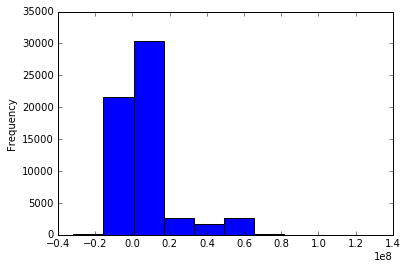

In [17]:
# Histogram of time to close a ticket
time_to_close["time2close"].plot(kind="hist")

We see from the chart that there are some negative time to close values.

Because in selecting the issues from gerrit we have included in our conditions the omes that have been abandoned too, the consequence is that in the data frame above we gain some negative values. This happens because some issues open at a certain time, somewhere were, for some reason, were abandoned. A ticket is opened later than the date where the issue was abandoned. The bug stated in the ticket is related to the issue abandoned. So the issue gets restored, and merged, fixing the ticket. 

For the purpose of our analysis, we have extracted and gathered the data so that we have one entry that matches the ticket with the abandonement (which gives a negative time to close due to the fact that the ticket is opened after the abandonement of the issue) and another entry that matches the ticket with the merge of the issue (which is the correct match for measuring time to close).

Given these facts we can delete from the data frame all the rows for which time to close is negative.
But first lets migrate the time from seconds to days and add a new column with this data in the dataframe.

In [18]:
# Migrate seconds to days - add another column to the data frame
time_to_close["time2close_days"] = (time_to_close["time2close"]/3600)/24

In [19]:
# Time to close a ticket - eliminating Abandoned phases
time_to_close_H1 = time_to_close[time_to_close["time2close"] >= 0];

In [21]:
# time_to_close_H1

### Retry the histogram on the new data frame to verify the elimination of the negative time to close:

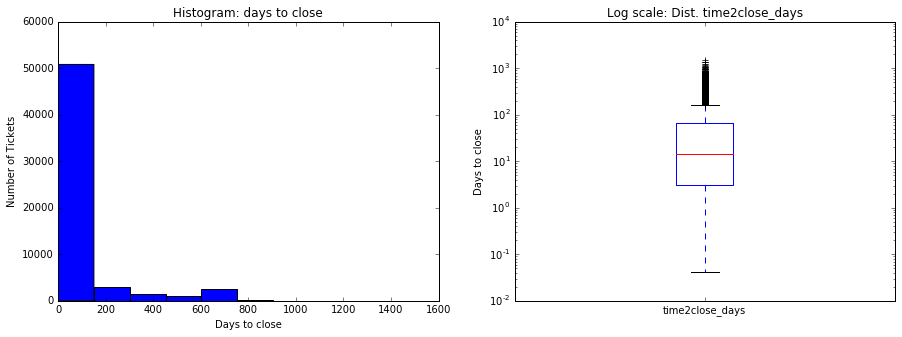

In [22]:
# Histogram of time to close a ticket
fig, axs = plt.subplots(1,2, figsize=(15,5))

hist_chart= time_to_close_H1["time2close_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time_to_close_H1["time2close_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to close")
hist_chart.set_ylabel("Number of Tickets")
hist_chart.set_title("Histogram: days to close")

boxplot_chart.set_ylabel("Days to close")
boxplot_chart.set_title("Log scale: Dist. time2close_days")

In [23]:
import matplotlib.pyplot as plt

# Measuring Time - Metric 1

The next calculates the average time for closing a single ticket. Note than when a ticket has been merged in different projects, all the different issues in gerrit contribute to the evolution of the ticket's life. The scenario is illustrated below:

                    |___________________GERRIT________________________| ...
           |-------------|--------------|--------|----------- ... ----| ...
         ticket         1st            2nd      3rd                  n-th 
         in lp         merge          merge    merge                 merge
           |_____________| +
           |____________________________| +                               --> the average of these intervals is what
           |_____________________________________| +                          we analyze in the next steps.
           |__________________________________________________________|  
         

In [24]:
query1 = """ select launchpad_issue,
                    gerrit_id,
                    launchpad_opening_date,
                    gerrit_closing_date,
                    timestampdiff(SECOND, launchpad_opening_date, gerrit_closing_date) as time2close,
                    current_status,
                    gerrit_project as gerrit_tracker
                    from lp_cr_aggregation
                    where gerrit_closing_date > launchpad_opening_date """

In [26]:
data1 = execute_query(cursor, query1)

/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'launchpad_opening_date' at row 2356
/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'launchpad_opening_date' at row 2468
/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'launchpad_opening_date' at row 2645
/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'launchpad_opening_date' at row 2663
/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'launchpad_opening_date' at row 2674
/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'launchpad_opening_date

In [27]:
data_list1 = list(data1)

In [28]:
time_to_close_1 = pandas.DataFrame(data_list1, columns=["launchpad_issue", "gerrit_id", "launchpad_opening_date", "gerrit_closing_date", "time2close", "current_status", "gerrit_tracker"])
time_to_close_1.columns.values.tolist()

['launchpad_issue',
 'gerrit_id',
 'launchpad_opening_date',
 'gerrit_closing_date',
 'time2close',
 'current_status',
 'gerrit_tracker']

In [29]:
# order dataframe by launchpad_issue
time2close_1 = time_to_close_1.sort_values(['launchpad_issue'])

In [30]:
# group by ticket
by_lp_issue = time2close_1.groupby(['launchpad_issue'])

In [31]:
groupby = by_lp_issue.mean()

In [32]:
print "Average time for closing a ticket: %f days" % ((groupby.mean()/3600.0)/24)
print "Median time for closing a ticket: %f days" % ((groupby.median()/3600.0)/24)
print "Quantiles: "
print groupby.quantile([0.25, 0.5, 0.75])

Average time for closing a ticket: 36.825899 days
Median time for closing a ticket: 8.020388 days
Quantiles: 
      time2close
0.25    157979.5
0.50    692961.5
0.75   2763054.0


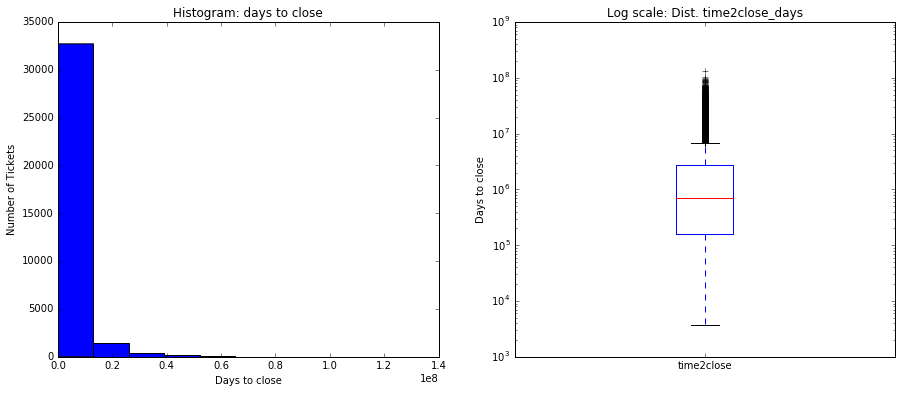

In [33]:
# Histogram of the mean time for closing a ticket
fig, axs = plt.subplots(1,2, figsize=(15,6))

hist_chart1= groupby["time2close"].plot(kind="hist", ax=axs[0])
boxplot_chart1 = groupby["time2close"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart1.set_xlabel("Days to close")
hist_chart1.set_ylabel("Number of Tickets")
hist_chart1.set_title("Histogram: days to close")

boxplot_chart1.set_ylabel("Days to close")
boxplot_chart1.set_title("Log scale: Dist. time2close_days")

### *** Measuring the behaviour of the time to close a ticket during the years ***

# MEASURING TIME - METRIC 2

The next calculates the time to closing a ticket. The scenario is illustrated below:

                    |___________________GERRIT________________________| ...
           |-------------|--------------|--------|----------- ... ----| ...
         ticket         1st            2nd      3rd                  n-th 
         in lp         merge          merge    merge                 merge
           |__________________________________________________________| --> this is what we analyze in the next steps 

In [34]:
query2 = """ select launchpad_issue,
                    gerrit_id,
                    launchpad_opening_date,
                    MAX(gerrit_closing_date),
                    timestampdiff(SECOND, launchpad_opening_date, MAX(gerrit_closing_date)) as time2close,
                    current_status
                    from lp_cr_aggregation
                    where current_status='MERGED'
                    group by launchpad_opening_date
                    order by gerrit_closing_date """

In [35]:
data2 = execute_query(cursor, query2)

In [36]:
data_list2 = list(data2)

In [37]:
time_to_close_2 = pandas.DataFrame(data_list2, columns=["launchpad_issue", "gerrit_id", "launchpad_opening_date", "gerrit_closing_date", "time2close", "current_status"])
time_to_close_2.columns.values.tolist()

['launchpad_issue',
 'gerrit_id',
 'launchpad_opening_date',
 'gerrit_closing_date',
 'time2close',
 'current_status']

In [38]:
# Migrate seconds to days - add another column to the data frame
time_to_close_2["time2close_days"] = (time_to_close_2["time2close"]/3600)/24

In [39]:
# Time to close a ticket - eleminating Abandoned phases during code review
time_to_close_H2 = time_to_close_2[time_to_close_2["time2close"] >= 0];

In [41]:
# time_to_close_H2

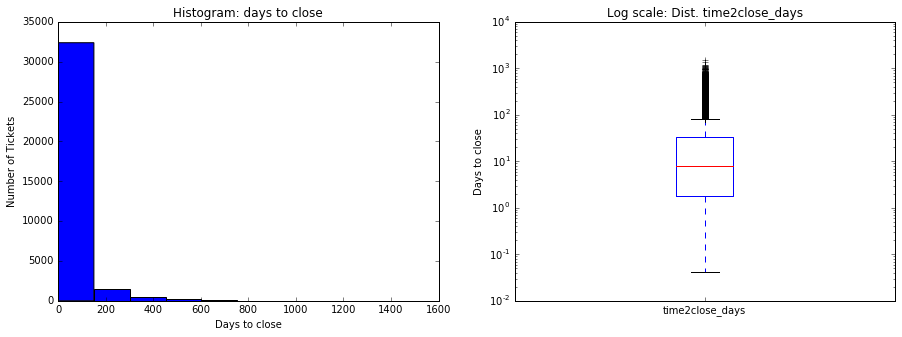

In [42]:
# Histogram of time to close a ticket
fig, axs = plt.subplots(1,2, figsize=(15,5))

hist_chart2 = time_to_close_H2["time2close_days"].plot(kind="hist", ax=axs[0])
boxplot_chart2 = time_to_close_H2["time2close_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart2.set_xlabel("Days to close")
hist_chart2.set_ylabel("Number of Tickets")
hist_chart2.set_title("Histogram: days to close")

boxplot_chart2.set_ylabel("Days to close")
boxplot_chart2.set_title("Log scale: Dist. time2close_days")

In [43]:
time_to_close_H3 = time_to_close_H2["time2close_days"]

In [44]:
print "Average time for closing a ticket: %f days" % time_to_close_H3.mean()
print "Median time for closing a ticket: %f days" % time_to_close_H3.median()
print "Quantiles: "
print time_to_close_H3.quantile([0.25, 0.5, 0.75])

Average time for closing a ticket: 38.588081 days
Median time for closing a ticket: 8.064392 days
Quantiles: 
0.25     1.826892
0.50     8.064392
0.75    32.959175
Name: time2close_days, dtype: float64
